In [1]:
import parse

In [27]:
# Get all the pose sequences from the parser
# TODO: save these in the future
all_ps = parse.main()

# Consider only one of the PS. The order is:
# ['poses/bicep_bad_1', 'poses/bicep_bad_2', 'poses/bicep_bad_3', 'poses/bicep_bad_4', 'poses/bicep_bad_5', 'poses/bicep_bad_6', 'poses/bicep_bad_7', 'poses/bicep_bad_8', 'poses/bicep_bad_9', 'poses/bicep_good_1', 'poses/bicep_good_2', 'poses/bicep_good_3', 'poses/bicep_good_4', 'poses/bicep_good_5', 'poses/bicep_good_6']
ps = all_ps[1]

In [28]:
# Given a PS, we first want to identify which arm is in the viewpoint
# For every pose in the PS, count the number of times 
# shoulder/elbow/wrist is 0 for both left and right side.

# Count number of non-zeros in right and left
right_ct, left_ct = 0, 0

for pose in ps.poses:
    right_loc = [pose.rshoulder, pose.relbow, pose.rwrist]
    left_loc = [pose.lshoulder, pose.lelbow, pose.lwrist]
    for loc in right_loc:
        right_ct = right_ct + 1 if loc.x > 0 else right_ct
        right_ct = right_ct + 1 if loc.y > 0 else right_ct
    for loc in left_loc:
        left_ct = left_ct + 1 if loc.x > 0 else left_ct
        left_ct = left_ct + 1 if loc.y > 0 else left_ct

# Check which side has less 0's. Deal with tiebreaking later
side = "Right" if right_ct > left_ct else "Left"
print(side)

Right


In [29]:
# Compute the vector of the upper arm
upper_arm_vectors = []
for pose in ps.poses:
    if side == "Right":
        joints = [pose.rshoulder, pose.relbow, pose.rwrist]
    else:
        joints = [pose.lshoulder, pose.lelbow, pose.lwrist]
    vec = [joints[0].x - joints[1].x, joints[0].y - joints[1].y]
    upper_arm_vectors.append(vec)
print(upper_arm_vectors[15])

[-0.021763714295558456, -0.5613407180662886]


(114, 2)


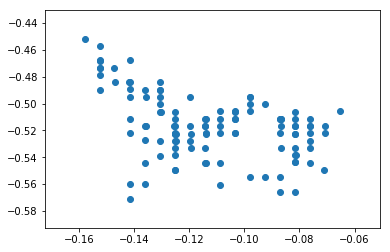

In [25]:
import numpy as np
import matplotlib.pyplot as plt
upper_arm_vectors = np.array(upper_arm_vectors)
print(upper_arm_vectors.shape)
plt.scatter(upper_arm_vectors[:,0], upper_arm_vectors[:,1])